<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Brain Observatory - Neuropixels </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Wednesday, August 28, 2019</h3> 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>This notebook will introduce you to the Neuropixel dataset and SDK functions. 

<p>
</div>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# tab completion in the notebook sometimes has trouble with large dataframes
# this will fix it
%config Completer.use_jedi = False

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # OS X 
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2019/"

manifest_path = os.path.join(data_root, "dynamic-brain-workshop/visual_coding_neuropixels/2019/manifest.json")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The main entry point is the `EcephyProjectCache` class.  This class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded onto the hard drives you have received, and is available on AWS.

<p>We begin by importing the `EcephysProjectCache` class and instantiating it.

<p>`manifest_path` is a path to the manifest file.  We will use the manifest file preloaded onto your Workshop hard drives.  Make sure that `drive_path` is set correctly for your platform.  (See the first cell in this notebook.)
</div>


In [3]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session

cache = EcephysProjectCache.fixed(manifest=manifest_path)

# 1. Exploring available sessions of the dataset

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  Get information about what's in the Neuropixel dataset from EcephysProjectCache

<p>Use the `get_sessions` function to retrieve a dataframe of all the available sessions. What information does this dataframe contain?

- How many sessions are there in the dataset?
- What is the average number of units in an experiment? The max number? The minimum?
- What are the different genotypes that were used in these experiments? How many sessions per genotype?
- What are all the brain structures that data has been collected from?
</div>

In [4]:
sessions = cache.get_sessions()

In [22]:
sessions.head()

,session_type,specimen_id,genotype,gender,age_in_days,project_code,probe_count,channel_count,unit_count,has_nwb,structure_acronyms
id,,,,,,,,,,,
737581020,brain_observatory_1.1,718643567,wt,M,108.0,NeuropixelVisualCoding,6,396,601,True,"[CA, DG, MB, TH, VISl, VISmma, VISp, VISpm, VI..."
739448407,brain_observatory_1.1,716813543,wt,M,112.0,NeuropixelVisualCoding,6,422,654,True,"[CA, DG, MB, TH, VIS, VISam, VISl, VISp, VISrl..."
744228101,brain_observatory_1.1,719817805,wt,M,122.0,NeuropixelVisualCoding,6,433,696,True,"[CA, DG, MB, TH, VIS, VISal, VISl, VISp, VISrl..."
746083955,brain_observatory_1.1,726170935,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,98.0,NeuropixelVisualCoding,6,412,628,True,"[CA, DG, MB, TH, VISal, VISl, VISp, VISpm, VIS..."
750749662,brain_observatory_1.1,726162197,wt,M,92.0,NeuropixelVisualCoding,6,509,813,True,"[CA, DG, MB, TH, VISal, VISam, VISl, VISp, VIS..."


How many sessions are available?

In [23]:
sessions.shape[0]

18

What's the average number of units in a session? The max? The min?

In [24]:
print(sessions.unit_count.mean())
print(sessions.unit_count.max())
print(sessions.unit_count.min())

709.2222222222222
1014
506


Text(0, 0.5, '# sessions')

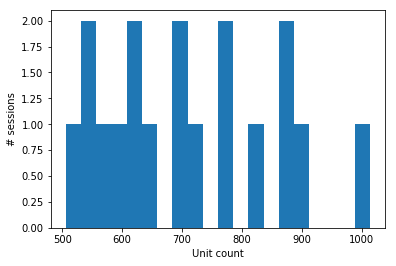

In [25]:
plt.hist(sessions.unit_count, bins=20);
plt.xlabel("Unit count")
plt.ylabel("# sessions")

What are the different genotypes that were used for this dataset? How many sessions per genotype are available?

In [26]:
sessions.genotype.value_counts()

wt                                                 8
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      4
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    3
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      3
Name: genotype, dtype: int64

What are the different session types? How many sessions per type?

In [27]:
sessions.session_type.value_counts()

brain_observatory_1.1    18
Name: session_type, dtype: int64

What are all the structures that data has been collected from?

In [28]:
all_areas = []
for index,row in sessions.iterrows():
    for a in row.structure_acronyms:
        if a not in all_areas:
            all_areas.append(a)

In [29]:
print(all_areas)

['CA', 'DG', 'MB', 'TH', 'VISl', 'VISmma', 'VISp', 'VISpm', 'VISrl', None, 'VIS', 'VISam', 'VISal', 'VISmmp']


To get more information about these structures, visit [our reference atlas web app](http://atlas.brain-map.org/atlas?atlas=602630314).

How many sessions have data from VISp?

In [30]:
count=0
for index,row in sessions.iterrows():
    if 'VISp' in row.structure_acronyms:
        count+=1
print(count)

18


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The session object</h2>
<p>The session object contains all the data and metadata for a single experiment session, including spike times, stimulus information, unit waveforms and derived metrics, LFP, and the mouse's running speed. 

<p>The session object is accessed using `cache.get_session_data(session_id)`

<p>**Note: experiment data is loaded upon initialization of the class. Some data can be accessed directly as an attribute of the class, others by using 'get' functions. 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.2:</b>  Let's pick one session to examine in greater detail. Select a `brain_observatory_1.1` session. Feel free to use other metadata to select one session and get the session_id (the index).

</div>

In [5]:
session_id = sessions[(sessions.unit_count>1000)&(sessions.session_type=='brain_observatory_1.1')
                      &(sessions.genotype=='wt')].index[0]
print(session_id)

757216464


Which areas were recorded from in this session?

In [32]:
sessions.structure_acronyms[session_id]

['CA',
 'DG',
 'MB',
 'TH',
 'VIS',
 'VISal',
 'VISam',
 'VISl',
 'VISp',
 'VISrl',
 None]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.3:</b>  Get the data for this session.  

<p> Use the `get_session_data` function of the cache to get the session object for this session. This object contains the data that is stored in the NWB file.
</div>

In [6]:
session = cache.get_session_data(session_id)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 2. Unit properties</h2>

<p> The primary data in this dataset is the recorded acrtivity of isolated units. A number of metrics are used to isolate units through spike sorting, and these metrics can be used to access how well isolated they are and the quality of each unit. The `units` dataframe provides many of these metrics, as well as parameterization of the waveform for each unit that passed initial QC, including
<p>

<li> <b>firing rate:</b> mean spike rate during the entire session
<li> <b>presence ratio:</b> fraction of session when spikes are present
<li> <b>ISI violations:</b> rate of refractory period violations
<li> <b>Isolation distances:</b> distance to nearest cluster in Mihalanobis space
<li> <b>d':</b> classification accuracy based on LDA
<li> <b>SNR:</b> signal to noise ratio
<li> <b>Maximum drift:</b> Maximum change in spike depth during recording
<li> <b>Cumulative drift:</b> Cumulative change in spike depth during recording

<p>
<li> <b>1D Waveform features:

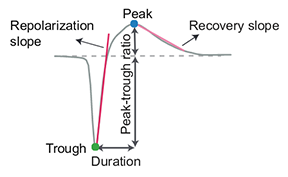


<p>For more information on these:
<li>https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/quality_metrics
<li>https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms



</div>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.1: Units</b>  

<p> Get the `units` dataframe for this session. 

What the the metrics? (i.e. what are the columns for the dataframe?

How many units are there? How many units per structure?
</div>

In [30]:
session.units.head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,channel_local_index,structure_acronym,structure_id,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,lfp_sampling_rate,location,sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,
914602976,0.346582,100.057815,0.026085,5,137.52,3.335647,31.839506,0.024853,95.979386,0.036386,...,13,TH,549.0,11,757968489,140,probeA,2499.99703,,29999.964361
914602974,0.684731,120.798210,0.043860,4,200.04,3.853885,28.346921,0.008103,69.787442,0.070177,...,13,TH,549.0,11,757968489,140,probeA,2499.99703,,29999.964361
914602978,0.189503,76.722945,0.023672,6,310.35,3.862677,0.279998,0.000000,41.314878,0.006293,...,17,TH,549.0,11,757968489,180,probeA,2499.99703,,29999.964361
914602984,1.166022,69.630405,0.023543,9,260.19,5.897170,4.155625,0.028102,95.849442,0.000610,...,16,TH,549.0,43,757968489,180,probeA,2499.99703,,29999.964361
914602994,0.527284,122.473455,0.003017,14,188.33,4.807625,9.868341,0.015365,71.310975,0.003246,...,37,TH,549.0,11,757968489,380,probeA,2499.99703,,29999.964361


In [31]:
session.units.columns

Index(['PT_ratio', 'amplitude', 'amplitude_cutoff', 'cluster_id',
       'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations',
       'isolation_distance', 'l_ratio', 'local_index_unit', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio',
       'recovery_slope', 'repolarization_slope', 'silhouette_score', 'snr',
       'spread', 'velocity_above', 'velocity_below', 'waveform_duration',
       'waveform_halfwidth', 'channel_local_index', 'structure_acronym',
       'structure_id', 'probe_horizontal_position', 'probe_id',
       'probe_vertical_position', 'probe_description', 'lfp_sampling_rate',
       'location', 'sampling_rate'],
      dtype='object')

How many units are in this session?

In [32]:
session.units.shape[0]

654

Which areas (structures) are they from?

In [33]:
print(session.units.structure_acronym.unique())

['TH' 'DG' 'CA' 'VISam' 'MB' 'VIS' 'VISp' 'VISl' 'VISrl']


How many units per area are there?

In [34]:
session.units.structure_acronym.value_counts()

CA       147
TH       126
VIS      100
VISrl     71
DG        64
VISam     58
VISl      36
MB        33
VISp      19
Name: structure_acronym, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.3:</b> Select 'good' units  

<p> A default is to include units that have a SNR greater than 1 and ISI violations less than 0.5  Plot a histogram of the values for each of these metrics? How many units meet these criteria? How many per structure?

</div>

plot a histogram for SNR

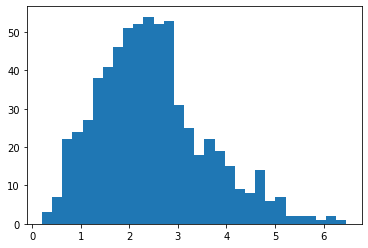

In [36]:
plt.hist(session.units.snr, bins=30);

plot a histogram for ISI violations

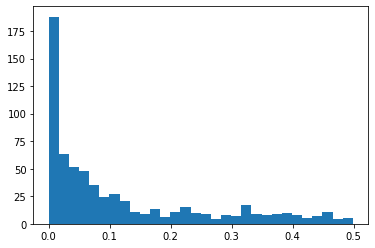

In [37]:
plt.hist(session.units.isi_violations, bins=30);

In [7]:
good_units = session.units[(session.units.snr>1)&(session.units.isi_violations<0.5)]
len(good_units)

995

In [8]:
good_units.structure_acronym.value_counts()

TH       333
CA       167
VISp      85
MB        79
VISam     65
DG        62
VIS       60
VISl      52
VISal     52
VISrl     40
Name: structure_acronym, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.4:</b> Compare the firing rate of good units in different structures

<p> Make a violinplot of the overall firing rates of units across structures.

</div>

In [37]:
import seaborn as sns

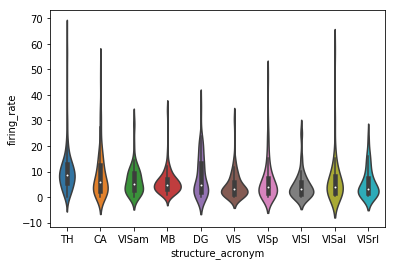

In [38]:
sns.violinplot(y='firing_rate', x='structure_acronym',data=good_units)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.5:</b> Plot the location of the units on the probe

<p> Color each structure a different color. What do you learn about the vertical position values?

</div>

Text(0, 0.5, 'Unit count')

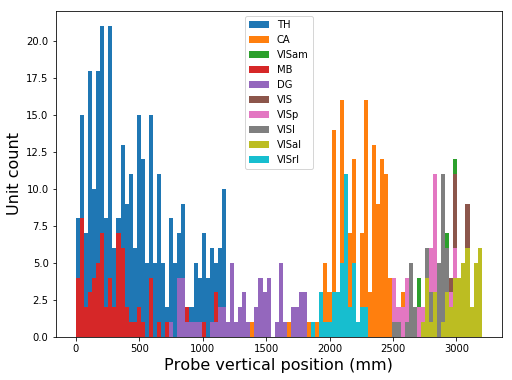

In [39]:
plt.figure(figsize=(8,6))
for structure in good_units.structure_acronym.unique():
    plt.hist(good_units[good_units.structure_acronym==structure].probe_vertical_position.values, bins=100, range=(0,3200), label=structure)
plt.legend()
plt.xlabel('Probe vertical position (mm)', fontsize=16)
plt.ylabel('Unit count', fontsize=16)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Spike Times</h2>

<p> The primary data in this dataset is the recorded acrtivity of isolated units. The `spike times` is a dictionary of spike times for each units in the session.

</div>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.6: Spike Times</b>

<p> Next let's find the `spike_times` for these units.

</div>

In [9]:
spike_times = session.spike_times

What type of object is this?

In [ ]:
type(spike_times)

How many items does it include?

In [45]:
len(spike_times)

654

In [46]:
len(session.units)

654

What are the keys for this object?

In [47]:
list(spike_times.keys())[:5]

[914602976, 914602974, 914602984, 914602978, 914602994]

These keys are unit ids. Use the unit_id for the first unit to get the spike times for that unit. How many spikes does it have in the entire session?

In [48]:
spike_times[session.units.index[0]]

array([6.12474493e-01, 6.61541218e-01, 7.58474666e-01, ...,
       9.26842798e+03, 9.26844595e+03, 9.26847992e+03])

In [49]:
print(len(spike_times[session.units.index[0]]))

295086


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.7:</b> Get the spike times for the units in V1

<p> Use the units dataframe to identify units in 'VISp' and use the spike_times to get their spikes. Start just getting the spike times for the first unit identified this way. Plot a raster plot of the spikes during the first 5 minutes (300 seconds) of the experiment.

</div>

In [41]:
session.units[session.units.structure_acronym=='VISp'].head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,channel_local_index,structure_acronym,structure_id,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,lfp_sampling_rate,location,sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,
914681321,0.412638,174.228015,0.016084,505,303.96,4.208924,7.170369,0.011359,54.438059,0.013633,...,251,VISp,385.0,27,769322749,2520,probeC,2499.999004,,29999.988048
914681319,0.541205,124.152795,0.007658,504,139.52,4.817294,2.631766,0.016861,69.477305,0.000264,...,250,VISp,385.0,59,769322749,2520,probeC,2499.999004,,29999.988048
914681317,0.332958,105.272310,0.002722,503,93.70,4.002282,9.093407,0.023538,78.802785,0.002280,...,250,VISp,385.0,59,769322749,2520,probeC,2499.999004,,29999.988048
914681313,0.508020,93.862860,0.044943,501,263.16,4.080729,6.373673,0.045037,79.660501,0.000684,...,250,VISp,385.0,59,769322749,2520,probeC,2499.999004,,29999.988048
914681339,0.344280,155.542725,0.020258,515,189.30,4.551919,8.819636,0.246246,76.799306,0.001271,...,253,VISp,385.0,11,769322749,2540,probeC,2499.999004,,29999.988048


In [10]:
unit_id = session.units[session.units.structure_acronym=='VISp'].index[12]

Text(0.5, 0, 'Time (s)')

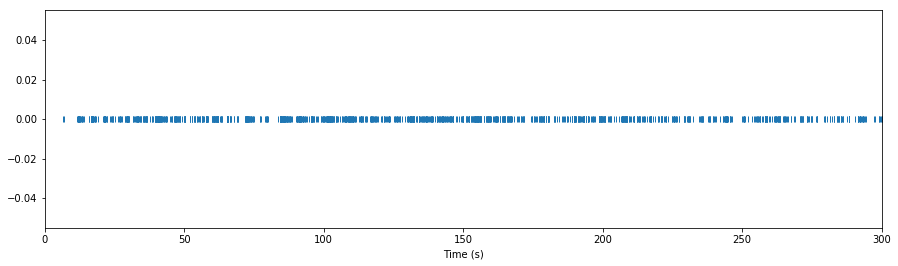

In [51]:
spikes = spike_times[unit_id]
plt.figure(figsize=(15,4))
plt.plot(spikes, np.repeat(0,len(spikes)), '|')
plt.xlim(0,300)
plt.xlabel("Time (s)")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.8:</b> Plot the firing rate for this units across the entire session

<p>A raster plot won't work for visualizing the activity across the entire session as there are too many spikes! Instead, bin the activity in 1 second bins. 

</div>

In [52]:
numbins = int(np.ceil(spikes.max()))
binned_spikes = np.empty((numbins))
for i in range(numbins):
    binned_spikes[i] = len(spikes[(spikes>i)&(spikes<i+1)])

Text(0, 0.5, 'FR (Hz)')

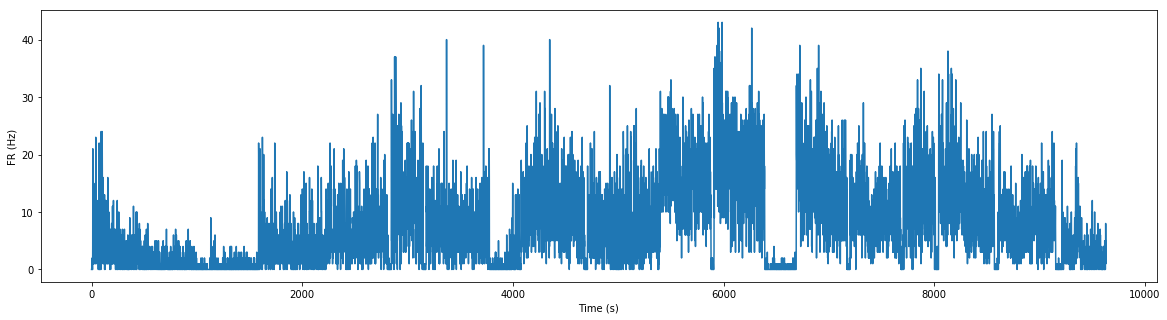

In [53]:
plt.figure(figsize=(20,5))
plt.plot(binned_spikes)
plt.xlabel("Time (s)")
plt.ylabel("FR (Hz)")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.9:</b> Plot firing rates for units in V1

<p> Now let's do this for up to 50 units in V1. Make an array of the binned activity of all units in V1 called 'v1_binned'. We'll use this again later.

</div>

In [54]:
v1_units = session.units[session.units.structure_acronym=='VISp']
numunits = len(v1_units)
if numunits>50:
    numunits=50
v1_binned = np.empty((numunits, numbins))
for i in range(numunits):
    unit_id = v1_units.index[i]
    spikes = spike_times[unit_id]
    for j in range(numbins):
        v1_binned[i,j] = len(spikes[(spikes>j)&(spikes<j+1)]) 

Plot the activity of all the units, one above the other

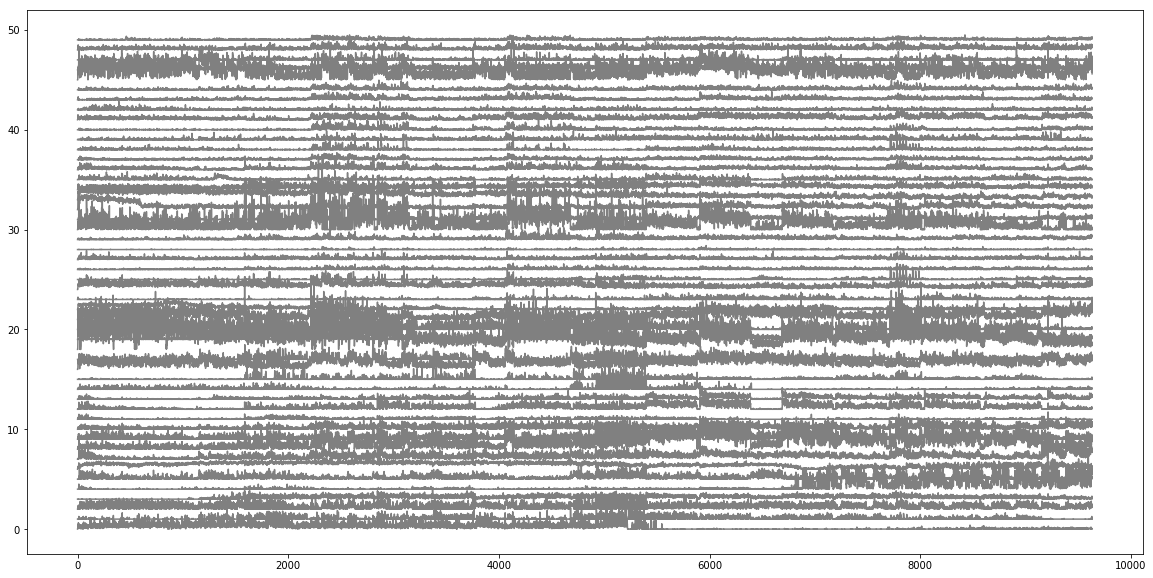

In [55]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(v1_binned[i,:]/30.), color='gray')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 3. Stimulus presentations</h2>

<p> A variety of visual stimuli were presented throughout the recording session, and the session object contains detailed information about what stimuli were presented when.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.1: Stimulus</b>

<p> What stimuli were presented in this session? Find the `stimulus_names` for the session.

</div>

In [57]:
session.stimulus_names

/local1/storage/envs/allensdk3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.2:</b> Stimulus epochs

<p> These stimuli are interleaved throughout the session. We can use the `stimulus_epochs` to see when each stimulus type was presented. Then we'll add this to the activity plot we made above.

</div>

In [48]:
stimulus_epochs = session.get_stimulus_epochs()
stimulus_epochs

/Users/saskiad/anaconda2/envs/ecephys/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,start_time,stop_time,duration,stimulus_name,stimulus_block
0,24.809045,84.875815,60.066770,spontaneous,null
1,84.875815,996.871167,911.995353,gabors,0
2,996.871167,1285.862685,288.991517,spontaneous,null
3,1285.862685,1584.362117,298.499433,flashes,1
4,1584.362117,1586.113585,1.751467,spontaneous,null
5,1586.113585,2185.614585,599.501000,drifting_gratings,2
6,2185.614585,2216.640485,31.025900,spontaneous,null
7,2216.640485,2817.142335,600.501850,natural_movie_three,3
8,2817.142335,2847.167375,30.025040,spontaneous,null
9,2847.167375,3147.418285,300.250910,natural_movie_one,4


Remake our plot of V1 activity from above, adding this stimulus epoch information. Shade each stimulus with a unique color. The <b>plt.axvspan()</b> is a useful function for this.

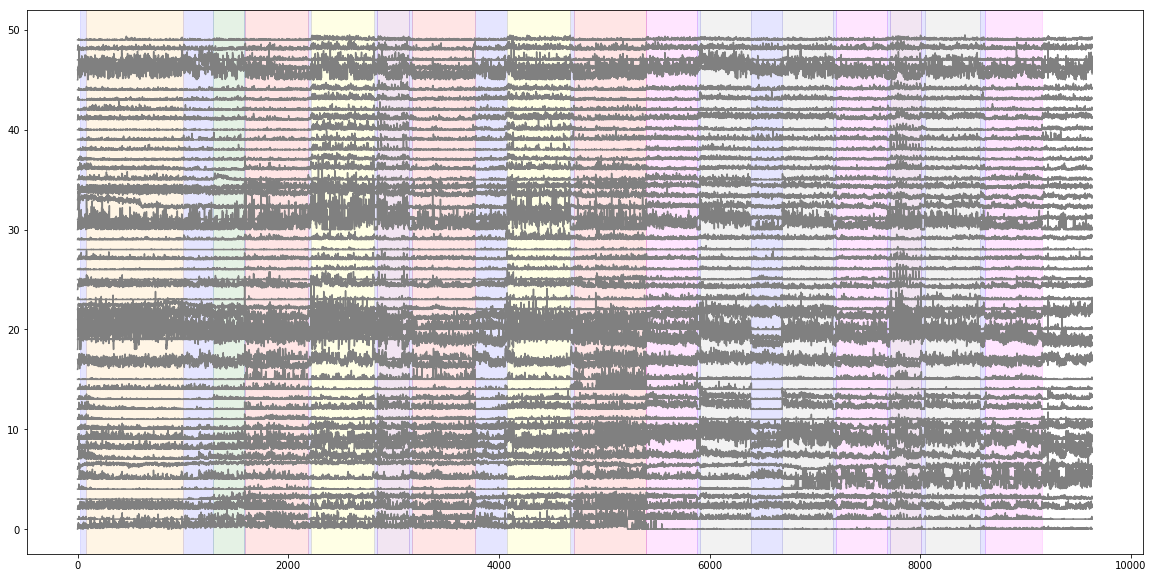

In [56]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(v1_binned[i,:]/30.), color='gray')

colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c, stim_name in enumerate(session.stimulus_names):
    stim = stimulus_epochs[stimulus_epochs.stimulus_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)


Before we dig into the stimulus information in more detail, let's find one more piece of session-wide data that's in the dataset. Running speed.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.3:</b> Get the running speed

<p> Before we dig further into the stimulus information in more detail, let's add one more piece of session-wide data to our plot. The mouse's running speed.  

Get the `running_speed` and its time stamps from the session object. Plot the speed as a function of time.

</div>

Text(0, 0.5, 'Running speed (cm/s)')

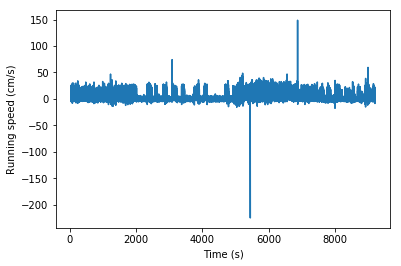

In [57]:
plt.plot(session.running_speed.end_time, session.running_speed.velocity)
plt.xlabel("Time (s)")
plt.ylabel("Running speed (cm/s)")

Add the running speed to the plot of V1 activity and stimulus epochs.

(-10, 52)

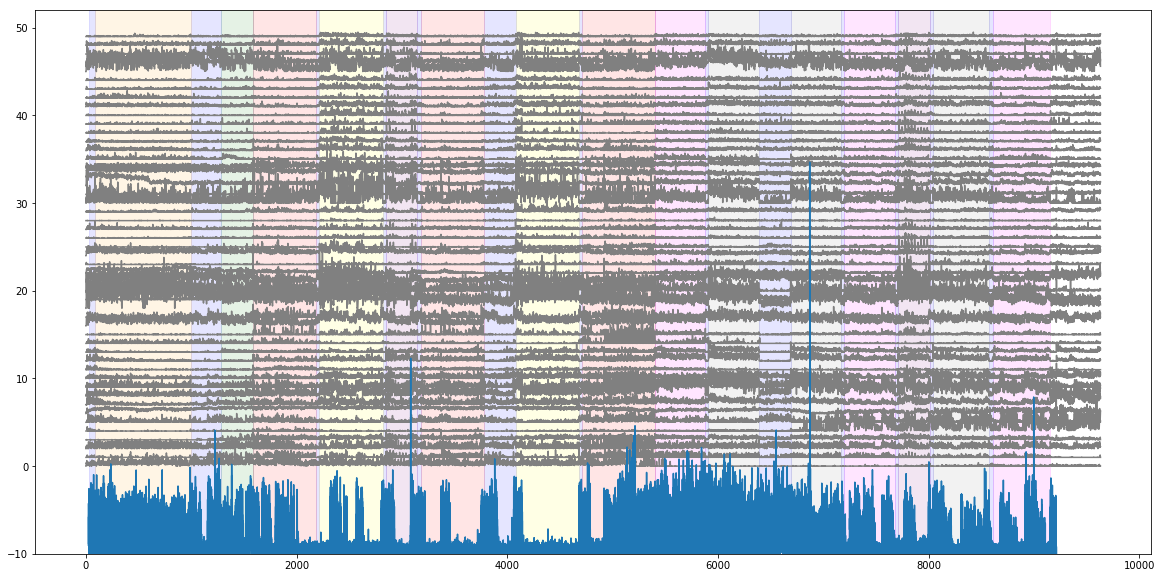

In [61]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(v1_binned[i,:]/30.), color='gray')

#scale the running speed and offset it on the plot
plt.plot(session.running_speed.end_time, (0.3*session.running_speed.velocity)-10)
    
colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c, stim_name in enumerate(session.stimulus_names):
    stim = stimulus_epochs[stimulus_epochs.stimulus_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)
        
plt.ylim(-10,52)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.4:</b> Stimulus presentations

<p> Now let's go back and learn more about the stimulus that was presented. The session object has a function that returns a table for a given stimulus called `get_presentations_for_stimulus`. 

Use this to get the stimulus table for drifting gratings and for natural scenes. What information do these tables provide? How are they different?

</div>


In [11]:
stim_table = session.get_presentations_for_stimulus('drifting_gratings')

/Users/saskiad/anaconda2/envs/ecephys/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:878: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: drifting_gratings
  warnings.warn(message)
/Users/saskiad/anaconda2/envs/ecephys/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [12]:
stim_table.head()

,contrast,orientation,spatial_frequency,temporal_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,
3798,0.8,90,0.04,1,1586.113585,2,drifting_gratings,1588.115245,2.00166,246
3799,0.8,0,0.04,8,1589.116095,2,drifting_gratings,1591.117775,2.00168,247
3800,0.8,90,0.04,8,1592.118605,2,drifting_gratings,1594.120275,2.00167,248
3801,0.8,135,0.04,15,1595.121125,2,drifting_gratings,1597.122785,2.00166,249
3802,0.8,315,0.04,1,1598.123625,2,drifting_gratings,1600.125295,2.00167,250


Now get the stimulus table for natural scenes. What is different about these tables?

In [64]:
stim_table_ns = session.get_presentations_for_stimulus('natural_scenes')

/home/tom.chartrand/work/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:878: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: natural_scenes
  warnings.warn(message)


In [65]:
stim_table_ns.head()

,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51355,96,5913.566500,9,natural_scenes,5913.816705,0.250205,4908
51356,72,5913.816705,9,natural_scenes,5914.066910,0.250205,4909
51357,102,5914.066910,9,natural_scenes,5914.317115,0.250205,4910
51358,55,5914.317115,9,natural_scenes,5914.567320,0.250205,4911
51359,57,5914.567320,9,natural_scenes,5914.817532,0.250213,4912


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.5:</b> Drifting gratings stimulus parameters

<p> Use the drifting grating stimulus table to determine what are the unique parameters for the different stimulus conditions of this stimulus.

</div>


In [66]:
stim_table.orientation.unique()

array([315.0, 225.0, 135.0, 180.0, 90.0, 45.0, 0.0, 270.0, 'null'],
      dtype=object)

In [67]:
stim_table.spatial_frequency.unique()

array([0.04, 'null'], dtype=object)

In [68]:
stim_table.temporal_frequency.unique()

array([1.0, 2.0, 4.0, 15.0, 8.0, 'null'], dtype=object)

In [69]:
stim_table.contrast.unique()

array([0.8, 'null'], dtype=object)

What do you think the 'null' conditions are?

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.6:</b> Natural scenes stimulus

<p> Use the stimulus table for natural scenes to find all the times when a particular image is presented during the session, and add it to the plot of activity in V1.  Pick the first image that was presented in this session.
</div>


In [70]:
stim_table_ns[stim_table_ns.frame==stim_table_ns.frame.iloc[0]].head()

,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51355,96,5913.566500,9,natural_scenes,5913.816705,0.250205,4908
51642,96,5985.376455,9,natural_scenes,5985.626660,0.250205,4908
51772,96,6017.903645,9,natural_scenes,6018.153850,0.250205,4908
51786,96,6021.406540,9,natural_scenes,6021.656740,0.250200,4908
51972,96,6067.945435,9,natural_scenes,6068.195640,0.250205,4908


How many times was it presented?

In [71]:
len(stim_table_ns[stim_table_ns.frame==stim_table_ns.frame.iloc[0]])

50

Mark the times when this particular scene was presented on our plot of the activity (without the epochs and running speed).

(5000, 9000)

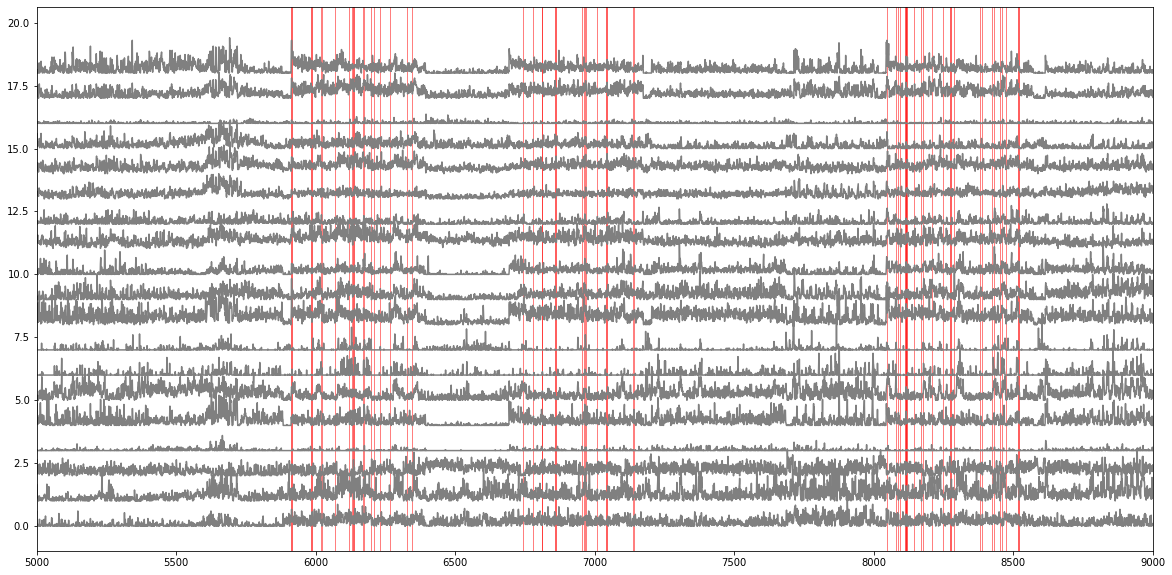

In [72]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(v1_binned[i,:]/30.), color='gray')
    
stim_subset = stim_table_ns[stim_table_ns.frame==stim_table_ns.frame.iloc[0]]
for j in range(len(stim_subset)):
    plt.axvspan(xmin=stim_subset.start_time.iloc[j], xmax=stim_subset.stop_time.iloc[j], color='r', alpha=0.5)
plt.xlim(5000,9000)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.7: Stimulus template</b> 

<p> What is this image? The `stimulus template` provides the images and movies that were presented to the mouse. These are only provided for stimuli that are images (natural scenes, natural movies) - parametric stimuli (eg. gratings) do not have templates.
</div>


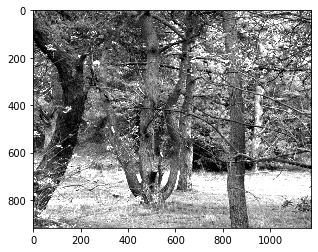

In [73]:
image_num = 96
image_template = cache.get_natural_scene_template(image_num)

plt.imshow(image_template, cmap='gray')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.8: </b> Single trial raster plots for all units.

<p>Now that we've seen the pieces of data, we can explore the neural activity in greater detail. Make a raster plot for a single presentation of the drifting grating stimulus at orientation=45 degrees and temporal frequency = 2 Hz.

To start, make a function to make a raster plot of all the units in the experiment.

</div>


In [74]:
def plot_raster(spike_times, start, end):
    num_units = len(spike_times)
    ystep = 1 / num_units

    ymin = 0
    ymax = ystep

    for unit_id, unit_spike_times in spike_times.items():
        unit_spike_times = unit_spike_times[np.logical_and(unit_spike_times >= start, unit_spike_times < end)]
        plt.vlines(unit_spike_times, ymin=ymin, ymax=ymax)

        ymin += ystep
        ymax += ystep
        

Find the first presentation of our chosen grating condition.

In [75]:
stim_table = session.get_presentations_for_stimulus('drifting_gratings')
subset = stim_table[(stim_table.orientation==45)&(stim_table.temporal_frequency==2)]
start = stim_table.start_time.iloc[0]
end = stim_table.stop_time.iloc[0]

/home/tom.chartrand/work/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:878: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: drifting_gratings
  warnings.warn(message)


Use the plot_raster function to plot the response of all units to this trial. Pad the raster plot with half a second before and after the trial, and shade the trial red (with an alpha of 0.1)

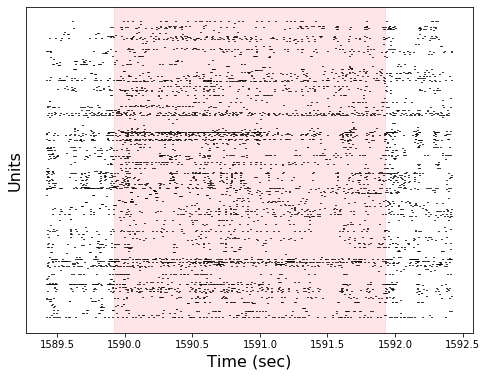

In [76]:
plt.figure(figsize=(8,6))
plot_raster(session.spike_times, start-0.5, end+0.5)
plt.axvspan(start, end, color='red', alpha=0.1)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Units', fontsize=16)
plt.tick_params(axis="y", labelleft=False, left=False)
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.9: </b> Single trial raster plots for all units.

<p>Use the `unit` dataframe to arrange the neurons in the raster plot according to their overall firing rate. 

</div>


In [77]:
session.units.sort_values(by="firing_rate", ascending=False).head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,channel_local_index,structure_acronym,structure_id,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,lfp_sampling_rate,location,sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,
914605360,0.434333,169.771290,0.003471,43,184.41,4.754126,54.898886,0.010789,163.299092,0.001171,...,73,DG,726.0,11,757968495,740,probeD,2499.993012,,29999.916144
914603752,0.374067,270.153195,0.000913,74,69.97,4.807550,48.601315,0.007585,99.753857,0.003421,...,68,MB,313.0,43,757968491,700,probeB,2499.992776,,29999.913307
914605288,0.669823,129.365730,0.011369,6,253.31,4.362436,47.992785,0.004618,91.127352,0.017959,...,8,TH,549.0,43,757968495,100,probeD,2499.993012,,29999.916144
914605282,0.648687,530.971935,0.000014,3,140.07,10.179073,47.744509,0.000000,140.416414,0.000001,...,5,TH,549.0,11,757968495,60,probeD,2499.993012,,29999.916144
914604780,0.340218,77.033385,0.035826,163,61.32,5.637110,44.022659,0.007220,1106.379134,0.000243,...,108,DG,726.0,43,757968493,1100,probeC,2499.999366,,29999.992397


Text(0.5, 0, 'Unit #')

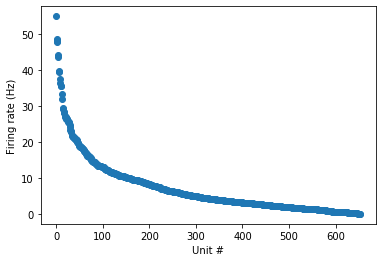

In [78]:
plt.plot(session.units.sort_values(by="firing_rate", ascending=False).firing_rate.values, 'o')
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Unit #")

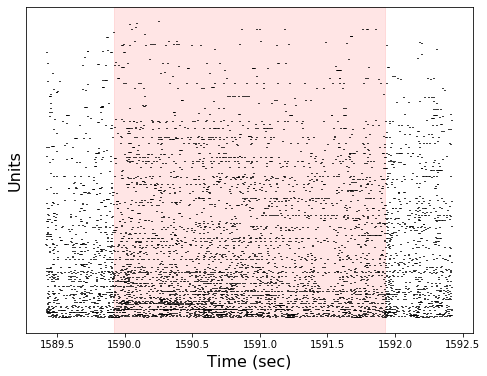

In [79]:
by_fr = session.units.sort_values(by="firing_rate", ascending=False)
spike_times_by_firing_rate = {
    uid: session.spike_times[uid] for uid in by_fr.index.values
}

plt.figure(figsize=(8,6))
plot_raster(spike_times_by_firing_rate, start-0.5, end+0.5)
plt.axvspan(start, end, color='red', alpha=0.1)
plt.ylabel('Units', fontsize=16)
plt.xlabel('Time (sec)', fontsize=16)
plt.tick_params(axis="y", labelleft=False, left=False)
plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 4. Unit waveforms</h2>

<p> For each unit, the average action potential waveform has been recorded from each channel of the probe. This is contained in the `mean_waveforms` object. This is the characteristic pattern that distinguishes each unit in spike sorting, and it can also help inform us regarding differences between cell types. 

<p>We will use this in conjuction with the `channel_structure_intervals` function which tells us where each channel is located in the brain. This will let us get a feel for the spatial extent of the extracellular action potential waveforms in relation to specific structures.


</div>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.0: Unit waveforms</b> 

<p> 

Get the waveform for one unit.
</div>

In [80]:
waveforms = session.mean_waveforms

What type of object is this?

In [81]:
type(waveforms)

dict

What are the keys?

In [82]:
list(waveforms.keys())[:5]

[914602976, 914602974, 914602984, 914602978, 914602994]

Get the waveform for one unit

In [13]:
unit = session.units.index.values[400]
wf = session.mean_waveforms[unit]

What type of object is this? What is its shape?

In [84]:
type(wf)

xarray.core.dataarray.DataArray

In [85]:
wf.coords

Coordinates:
  * channel_id  (channel_id) int64 850214511 850214513 ... 850215273 850215275
  * time        (time) float64 0.0 3.333e-05 6.667e-05 ... 0.002667 0.0027

In [86]:
wf.shape

(370, 82)

Text(0, 0.5, 'Channel #')

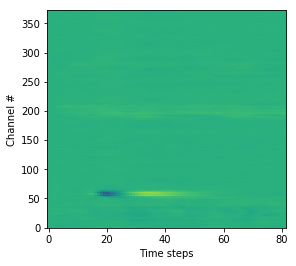

In [14]:
plt.imshow(wf, aspect=0.2, origin='bottom')
plt.xlabel('Time steps')
plt.ylabel('Channel #')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.1: Unit waveforms</b> 

<p> 
Use the `channel_structure_intervals` to get information about where each channel is located.

We need to pass this function a list of channel ids, and it will identify channels that mark boundaries between identified brain regions. 

<p>We can use this information to add some context to our visualization.
</div>


In [15]:
# pass in the list of channels from the waveforms data
structure_acronyms, intervals = session.channel_structure_intervals(wf.channel_id.values)
print(structure_acronyms)
print(intervals)

['TH' 'DG' 'CA' 'VISp' 'None']
[  0  98 166 243 340 373]


Place tick marks at the interval boundaries, and labels at the interval midpoints.

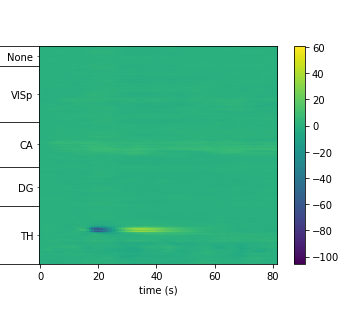

In [16]:
fig, ax = plt.subplots()
plt.imshow(wf, aspect=0.2, origin='bottom')
plt.colorbar(ax=ax)

ax.set_xlabel("time (s)")
ax.set_yticks(intervals)
# construct a list of midpoints by averaging adjacent endpoints
interval_midpoints = [ (aa + bb) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

plt.show()

Let's see if this matches the structure information saved in the units table:

In [17]:
session.units.loc[unit, "structure_acronym"]

'TH'

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.2: </b>Plot the mean waveform for the peak channel for each unit in the dentate gyrus (DG)

<p> Start by plotting the mean waveform for the peak channel for the unit we just looked at. 
Then do this for all the units in DG, making a heatmap of these waveforms
</div>

Find the peak channel for this unit, and plot the mean waveform for just that channel

In [91]:
session.units.loc[unit, 'peak_channel_id']

850214975

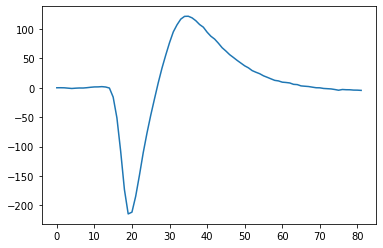

In [92]:
plt.plot(wf.loc[{"channel_id": 850214975}])

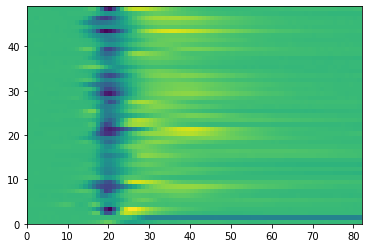

In [93]:
fig, ax = plt.subplots()

th_unit_ids = good_units[good_units.structure_acronym=="DG"].index.values

peak_waveforms = []

for unit_id in th_unit_ids:

    peak_ch = good_units.loc[unit_id, "peak_channel_id"]
    unit_mean_waveforms = session.mean_waveforms[unit_id]

    peak_waveforms.append(unit_mean_waveforms.loc[{"channel_id": peak_ch}])
    
    
time_domain = unit_mean_waveforms["time"]

peak_waveforms = np.array(peak_waveforms)
plt.pcolormesh(peak_waveforms)

# 5. Stimulus responses and coding
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 5. Stimulus responses</h2>

<p> A lot of the analysis of these data will requires comparing responses of neurons to different stimulus conditions and presentations. The SDK has functions to help access these, sorting the spike data into responses for each stimulus presentations and converting from spike times to binned spike counts. This spike histogram representation is more useful for many computations, since it can be treated as a timeseries and directly averaged across presentations. 

<p>The `presentationwise_spike_counts` provides the histograms for specified stimulus presentation trials for specified units. The function requires <b>stimulus_presentation_ids</b> for the stimulus in question, <b>unit_ids</b> for the relevant units, and <b>bin_edges</b> to specify the time bins to count spikes in (relative to stimulus onset).

<p>The `conditionwise_spike_statistics` creates a summary of specified units responses to specified stimulus conditions, including the mean spike count, standard deviation, and standard error of the mean.

</div>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.1: Presentation-wise analysis for drifting gratings</b>

<p>  

Pick  a specific condition of the drifting grating stimulus and create spike histograms for the units in V1.
<p>Create bins at a 10 ms resolution so we can see dynamics on a fast timescale.

</div>

In [94]:
stim_table.head()

,contrast,orientation,spatial_frequency,temporal_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,
3798,0.8,315,0.04,1,1589.92185,2,drifting_gratings,1591.92352,2.00167,246
3799,0.8,225,0.04,2,1592.92433,2,drifting_gratings,1594.92602,2.00169,247
3800,0.8,135,0.04,1,1595.92687,2,drifting_gratings,1597.92855,2.00168,248
3801,0.8,180,0.04,4,1598.92935,2,drifting_gratings,1600.93104,2.00169,249
3802,0.8,90,0.04,4,1601.93185,2,drifting_gratings,1603.93353,2.00168,250


In [18]:
# specify the time bins in seconds, relative to stimulus onset
time_step = 1/100.
duration = stim_table.duration.iloc[0]
time_domain = np.arange(0, duration+time_step, time_step)
print(time_domain.shape)

(202,)


In [19]:
stim_ids = stim_table[(stim_table.orientation==90)&(stim_table.temporal_frequency==1)].index
print(stim_ids.shape)

(15,)


In [22]:
histograms = session.presentationwise_spike_counts(bin_edges=time_domain, 
                                                   stimulus_presentation_ids=stim_ids, 
                                                   unit_ids=v1_units.index)

What type of object is this? What is its shape?

In [98]:
type(histograms)

xarray.core.dataarray.DataArray

In [23]:
histograms.shape

(15, 201, 85)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.2:</b> Plot the response of the first unit to all 15 trials

<p> 

</div>

Text(0, 0.5, 'Trials')

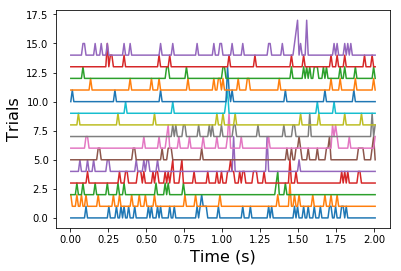

In [26]:
for i in range(15):
    plt.plot(histograms.time_relative_to_stimulus_onset, i+histograms[i,:,0])
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Trials", fontsize=16)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.2:</b> Compute the mean of the trials for all units, and plot a heatmap of mean response for all units in V1

<p> 

</div>

In [27]:
mean_histograms = histograms.mean(dim="stimulus_presentation_id")

In [28]:
mean_histograms.coords

Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.005 ... 2.005
  * unit_id                          (unit_id) int64 914681321 ... 914681739

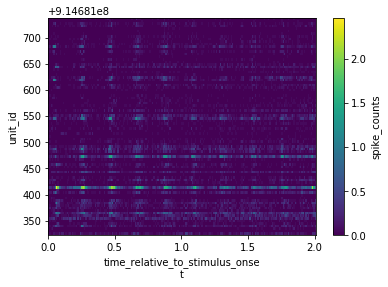

In [29]:
import xarray.plot as xrplot
xrplot.imshow(darray=mean_histograms, x="time_relative_to_stimulus_onset",
                                      y="unit_id")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.3: Conditionwise analysis</b> 

In order to compute a tuning curve that summarizes the responses of a unit to each stimulus condition of a stimulus, use the `conditionwise_spike_statistics` to summarize the activity of specific units to the different stimulus conditions.

<p> 

</div>

In [30]:
stim_ids = stim_table.index.values

In [31]:
dg_stats = session.conditionwise_spike_statistics(stimulus_presentation_ids=stim_ids, unit_ids=v1_units.index)

What type of object is this? What is its shape?

In [106]:
type(dg_stats)

pandas.core.frame.DataFrame

In [32]:
dg_stats.shape

(3485, 5)

What are its columns?

In [108]:
dg_stats.columns

Index(['spike_count', 'spike_mean', 'spike_sem', 'spike_std',
       'stimulus_presentation_count'],
      dtype='object')

Can you explain the first dimension?

In [109]:
dg_stats.head()

,,spike_count,spike_mean,spike_sem,spike_std,stimulus_presentation_count
unit_id,stimulus_condition_id,,,,,
914605088,246,21,1.400000,0.213809,0.828079,15
914605092,246,276,18.400000,1.614812,6.254141,15
914605096,246,33,2.200000,1.184021,4.585692,15
914605116,246,26,1.733333,0.482717,1.869556,15
914605122,246,367,24.466667,3.289039,12.738393,15


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.4: </b> Merge the conditionwise statistics with stimulus information

In order to link the stimulus responses with the stimulus conditions, merge the spike_statistics output with the stimulus table using `pd.merge()`.

<p> 

</div>

In [48]:
dg_stats_stim = pd.merge(dg_stats, session.stimulus_conditions, on='stimulus_condition_id', right_index=True)

This dataframe currently has a *multi-index*, meaning that each row is indexed by the pair of unit_id and stimulus_condition_id. 

In [49]:
dg_stats_stim.head()

,,spike_count,spike_mean,spike_sem,spike_std,stimulus_presentation_count,color,contrast,frame,orientation,phase,x_position,y_position,spatial_frequency,temporal_frequency,stimulus_name
unit_id,stimulus_condition_id,,,,,,,,,,,,,,,
914681313,246,386,25.733333,1.541387,5.969765,15,null,0.8,null,90,null,null,null,0.04,1,drifting_gratings
914681317,246,32,2.133333,0.945499,3.661902,15,null,0.8,null,90,null,null,null,0.04,1,drifting_gratings
914681319,246,4,0.266667,0.206252,0.798809,15,null,0.8,null,90,null,null,null,0.04,1,drifting_gratings
914681321,246,320,21.333333,2.703907,10.472185,15,null,0.8,null,90,null,null,null,0.04,1,drifting_gratings
914681327,246,96,6.400000,1.017934,3.942443,15,null,0.8,null,90,null,null,null,0.04,1,drifting_gratings


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.5: </b> Plot a 2D tuning curve for the first unit, comparing responses across temporal frequency and orientation.


<p> 

</div>

In [54]:
unit_id = v1_units.index[1]

In [35]:
stim_ids = stim_table.index.values
session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids, drop_nulls=True)

{'contrast': array([0.8], dtype=object),
 'orientation': array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0], dtype=object),
 'spatial_frequency': array([0.04], dtype=object),
 'temporal_frequency': array([1.0, 2.0, 4.0, 8.0, 15.0], dtype=object)}

In [36]:

orivals = session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids, drop_nulls=True)['orientation']
tfvals = session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids, drop_nulls=True)['temporal_frequency']

In [55]:
response_mean = np.empty((len(orivals), len(tfvals)))
response_sem = np.empty((len(orivals), len(tfvals)))
for i,ori in enumerate(orivals):
    for j,tf in enumerate(tfvals):
        stim_id = stim_table[(stim_table.orientation==ori)&(stim_table.temporal_frequency==tf)].stimulus_condition_id.iloc[0]
        response_mean[i,j] = dg_stats_stim.loc[(unit_id, stim_id)].spike_mean
        response_sem[i,j] = dg_stats_stim.loc[(unit_id, stim_id)].spike_sem


([<matplotlib.axis.YTick at 0x193b5d780>,
 <a list of 8 Text yticklabel objects>)

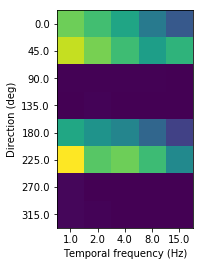

In [56]:
plt.imshow(response_mean)
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Direction (deg)")
plt.xticks(range(5), tfvals)
plt.yticks(range(8), orivals)

# 6. Local Field Potential (LFP)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.1: Local Field Potential (LFP)</b>


<p> The final aspect of a Neuropixels probe recording we will investigate is the local field potential (LFP). An LFP signal is a direct recordings of extracellular voltage from which individual spike contributions have been removed by low-pass filtering. The remaining signal reflects the population activity of a large number of cells in the vicinity of the probe, primarily through the electrical field effects of synaptic currents (along with other trans-membrane currents).

LFP can be especially informative for understanding rhythmic activity or oscillations in neural circuits, which can be identified by some simple time-series analysis of the LFP signals.

</div>




### Accessing data

We'll start by loading the LFP data from one of the probes in our session.

We need to provide this function with a probe id, which we can pull out of the `session.probes` table. 

(Note that the "id" column is the index of the dataframe, and thus must be accessed differently than other columns.)

In [117]:
probe_id = session.probes.index[0]
lfp = session.get_lfp(probe_id)
print(lfp)

<xarray.DataArray 'LFP' (time: 11584906, channel: 77)>
array([[-138, -160, -169, ...,   10,   -6,    0],
       [-320, -160, -171, ...,  -65,   69,   59],
       [-219,  -78, -145, ...,   -5,   78,   28],
       ...,
       [-129, -166,   26, ...,   85,  145,    0],
       [ -10, -123,  124, ...,   64,  214,   40],
       [-186, -145,  -13, ...,    0,   70,    4]], dtype=int16)
Coordinates:
  * time     (time) float64 0.5656 0.5664 0.5672 ... 9.268e+03 9.269e+03
  * channel  (channel) int64 850211247 850211255 ... 850211847 850211855


### Plot the LFP data array

To visualize this data, we'll first use the built-in xarray plotting to generate a quick plot. This is too much data to plot all at once, so we select a subset first. Just as in pandas, we use the `loc` property, but since xarray has named dimensions, we can specify our selections by name rather than by order, using a dict.

We'll also add the structure boundaries to this plot, as we did with unit waveforms.

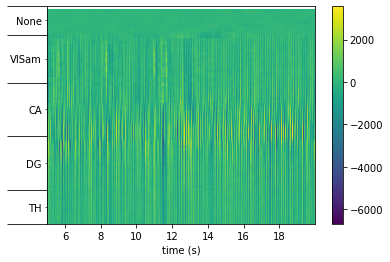

In [118]:
fig, ax = plt.subplots()
lfp_plot = lfp.loc[dict(time=slice(5,20))]
x, y = lfp_plot.time, range(len(lfp_plot.channel))
plt.pcolormesh(x, y, lfp_plot.values.T)
plt.colorbar(ax=ax)

ax.set_xlabel("time (s)")

# include the structure data
structure_acronyms, intervals = session.channel_structure_intervals(lfp.channel.values)
ax.set_yticks(intervals)
interval_midpoints = [ (aa + bb) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.2: Plot and filter single-channel LFP timeseries</b>

</div>




We'll start by plotting the timeseries of a single channel.

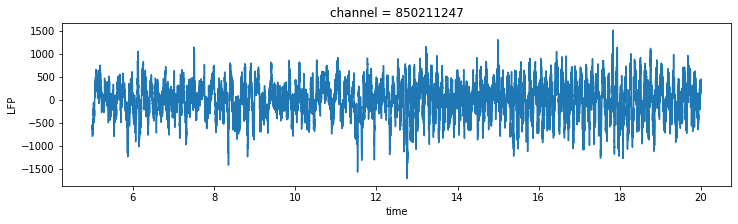

In [119]:
channel = lfp.channel[0]
lfp_subset = lfp.loc[dict(channel=channel, time=slice(5,20))]

# you might then want to clear the full LFP from memory if not using it
# lfp = None

plt.figure(figsize=(12,3))
lfp_subset.plot()

We might also want to visualize a specific frequency band by filtering. To do this we'll want to convert our data into standard numpy arrays for easier processing using the DataArray object's `values` property.

In [120]:
t = lfp_subset.time.values
v = lfp_subset.values

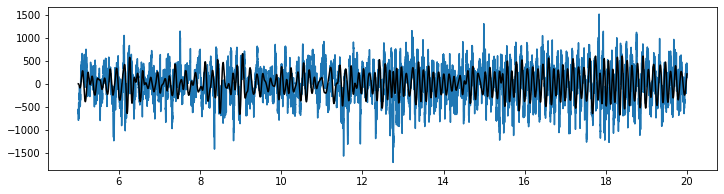

In [121]:
import scipy.signal
freq_window = (4, 10)
filt_order = 3
fs = 1/(t[1]-t[0])
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)
v_alpha = scipy.signal.lfilter(b, a, v)


plt.figure(figsize=(12,3))
plt.plot(t, v)
plt.plot(t, v_alpha,'k')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.3: LFP Power spectral density (PSD)</b>


<p> Next we're going to analyze some spectral properties of this signal using the `scipy.signal` library. "Spectral" refers to decomposing a signal into a sum of simpler components identified by their frequencies. The set of frequencies of the components forms a *spectrum* that tells us about the complete signal. You can see a full list of spectral analysis functions in scipy here: https://docs.scipy.org/doc/scipy/reference/signal.html#spectral-analysis

</div>




We first import the package, and inspect the `periodogram` function, which estimates the size of the different frequency components of the signal.

In [122]:
import scipy.signal
help(scipy.signal.periodogram)

Help on function periodogram in module scipy.signal.spectral:

periodogram(x, fs=1.0, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
    Estimate power spectral density using a periodogram.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length must be nperseg. Defaults
        to 'boxcar'.
    nfft : int, optional
        Length of the FFT used. If `None` the length of `x` will be
        used.
    detrend : str or function or `

There are a number of options that we won't go into here for refining the analysis. The one piece of information we do need is `fs`, the sampling frequency. If we used the default value `fs=1.0` our results would not match the true frequencies of the signal.

In [123]:
fs = 1/(t[1]-t[0])

f, psd = scipy.signal.periodogram(v, fs)

We'll plot the power spectrum on a semilog plot, since power can vary over many orders of magnitude across frequencies.

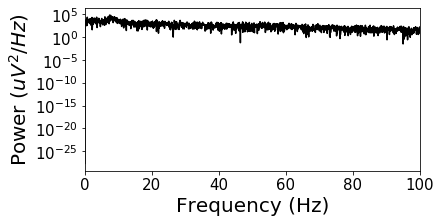

In [124]:
plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,100))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.show()

We see that this representation of the power spectrum is extremely noisy. Luckily, many people have come up with solutions to this problem. Scipy includes a function for Welch's method, which averages out noise by computing many estimates of the power spectrum from overlapping windows of the data. You can find some more references for this approach in the Scipy documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch

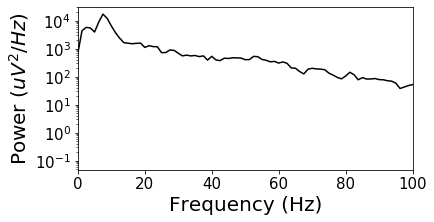

In [125]:
f, psd = scipy.signal.welch(v, fs, nperseg=1000)

plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,100))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.4: Calculate and plot the time-frequency profile ("spectrogram")</b>


<p> We might also be interested in how the frequency content of the signal varies over time. In a neural context, power in different frequency bands is often linked to specific types of processing, so we might explore whether changes in the spectrum coincide with specific behaviors or stimuli.</p>
<p>
The *spectrogram* is essentially an estimate of the power spectrum computed in a sliding time window, producing a 2D representation of the signal power across frequency and time.</p>

</div>




In [126]:
f, t_spec, spec = scipy.signal.spectrogram(v, fs=fs, window='hanning',
                            nperseg=1000, noverlap=1000-1, mode='psd')
# Scipy assumes our signal starts at time=0, so we need to provide the offset
t_spec = t_spec + t[0]

We'll use the matplotlib `pcolormesh` function to visualize this data as an image. We can pass this function x and y coordinates to get the axis labeling right. We also log-transform the power spectrum and restrict to frequencies less than 100 Hz.

In [127]:
fmax = 80
x, y = t_spec, f[f<fmax]
plot_data = np.log10(spec[f<fmax])

We'll plot the spectrum together with the raw signal in subplots. Note that we explicitly set the x-axis limits to align the plots. (Alternatively, it's possible to directly couple the limits of different subplots.)

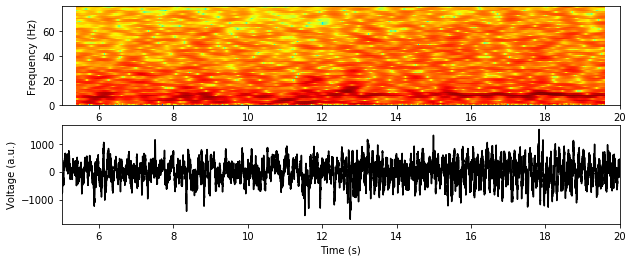

In [128]:
from matplotlib import cm
plt.figure(figsize=(10,4))

plt.subplot(2,1,1)
plt.pcolormesh(x, y, plot_data, cmap=cm.jet)
window = [5,20]
plt.xlim(window)
plt.ylabel('Frequency (Hz)')

plt.subplot(2,1,2)
plt.plot(t, v, 'k')
plt.xlim(window)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')
plt.show()